# Rental House Recommender Machine
This notebook;
1. Scrapes rental house ads from a real estate website
2. Gets borough informations from Foursquare
3. Clusters boroughs and houses seperately then merges them together
4. Based on the user input for house preferences, it recommend 5 houses.

In [1]:
!pip install geopy
!pip install folium

from bs4 import BeautifulSoup
import requests

import folium # map rendering library
from geopy.geocoders import Nominatim

import seaborn as seabornInstance 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
%matplotlib inline

import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn import metrics

from scipy import stats
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

---
## 1. This part will scrape Rental Prices from Real Estate Website
Location - Size[m2] - Room Count - Building Age - Price will be scraped

In [2]:
location_list = []
m2_list = []
price_list = []
room_list =[]
age_list =[]
link_list=[]

In [3]:
# @hidden_cell
website="https://www.hurriyetemlak.com/izmir-kiralik/daire?page="
    

BeautifulSoup will search though the pages from 1 to 201.    
On 09.05.2020 there are 201 pages of rental ads on the website

In [4]:
for i in range(1,202):
    data_link = website + str(i)
    try:
        page = requests.get(data_link, timeout=2)
    except:
        print("An exception occurred in page:", str(i))
    soup = BeautifulSoup(page.content, 'html.parser')
    price_soup = soup.find_all('div',class_='list-view-price')
    for price in price_soup:
        price_list.append(int(price.text.replace('\n','').replace(' TL','').replace(',','')))

    location_soup = soup.find_all('div',class_='list-view-location')
    for location in location_soup:
        location_list.append(location.text.replace('\n','').split(',')[0])

    m2_soup = soup.find_all('span',class_='celly squareMeter list-view-size')
    for m2 in m2_soup:
        m2_list.append(int(m2.text.replace('\n','').replace(' m2','').replace(',','')))

    room_soup = soup.find_all('span',class_='celly houseRoomCount')
    for room in room_soup:
        room_list.append((room.text.replace('\n','')))
        
    link_soup = soup.find_all('a',class_='img-link')
    for link in link_soup:
        link_list.append('www.hurriyetemlak.com'+link['href'])

    age_soup = soup.find_all('span',class_='celly buildingAge')
    for age in age_soup:
        try:
            age_list.append(int(age.text.replace('\n','').replace(' Yaşında', '').replace('Sıfır Bina', '0')))
        except:
            age_list.append(round(np.mean(age_list))) #If age not found, fill with mean of the others.
            
    #time.sleep(2) # Delay for 2 seconds to prevent issues with server.
    

Create a pandas dataframe with the results.    
Add price per squaremeter parameter in the end. **P/m2**

In [10]:
df_ads = pd.DataFrame({'Price': price_list, 'Size': m2_list, \
                   'Borough': location_list, 'Room#':room_list, 'Age':age_list, 'Link':link_list}) 
        
df_ads['P/m2'] = round(df_ads['Price'] / df_ads['Size'],0)
print(len(df_ads)) # Succesfully scraped
df_ads.head()

4824


,Price,Size,Borough,Room#,Age,Link,P/m2
0,1850,86,Karşıyaka,1+1,7,www.hurriyetemlak.com/izmir-karsiyaka-ornekkoy...,22.0
1,2250,140,Balçova,3+1,10,www.hurriyetemlak.com/izmir-balcova-koruturk-k...,16.0
2,42000,155,Çeşme,3+1,8,www.hurriyetemlak.com/izmir-cesme-musalla-kira...,271.0
3,1850,45,Bornova,Stüdyo,0,www.hurriyetemlak.com/izmir-bornova-kazimdirik...,41.0
4,1800,65,Karşıyaka,1+1,2,www.hurriyetemlak.com/izmir-karsiyaka-alaybey-...,28.0


In [11]:
df_ads.to_csv (r'house_ads.csv', index = False, header=True)

---
### Get the coordinates of Izmir Boroughs
The coordinates found by Nominatim are legal points but not the borough centrum in real life

In [12]:
geolocator = Nominatim(user_agent="my-application")
lats = []
longs = []
for borough in list(set(df_ads['Borough'])):
    location = geolocator.geocode(borough+",İzmir")
    lats.append(location.latitude)
    longs.append(location.longitude)
    time.sleep(1.2) #Nominatim user policy is 1 request per 1 second.

In [13]:
df_borough_lat_long = pd.DataFrame({'Borough':list(set(df_ads['Borough'])) , 'Latitude': lats, 'Longitude': longs})

In [14]:
df_borough_lat_long.head()

,Borough,Latitude,Longitude
0,Ödemiş,38.231341,27.975181
1,Menderes,38.149147,27.106591
2,Balçova,38.380478,27.055728
3,Konak,38.410958,27.129453
4,Karabağlar,38.347205,27.041274


In [15]:
def create_map(df):
    m = folium.Map(
            location=[38.356832, 26.930211],
            zoom_start=9
        )
    for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['Borough']):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=poi,
            color='#3186cc',
            fill=True,
            fill_color='#3186cc',
            ).add_to(m)
    return m

In [16]:
m=create_map(df_borough_lat_long)
m

Merge the coordinates to main DataFrame and store it in df_ads_lat_long

In [17]:
df_ads_lat_long = pd.merge(left=df_ads, right=df_borough_lat_long, left_on='Borough', right_on='Borough')

In [18]:
df_ads_lat_long

,Price,Size,Borough,Room#,Age,Link,P/m2,Latitude,Longitude
0,1850,86,Karşıyaka,1+1,7,www.hurriyetemlak.com/izmir-karsiyaka-ornekkoy...,22.0,38.503471,27.113483
1,1800,65,Karşıyaka,1+1,2,www.hurriyetemlak.com/izmir-karsiyaka-alaybey-...,28.0,38.503471,27.113483
2,2650,145,Karşıyaka,3+1,1,www.hurriyetemlak.com/izmir-karsiyaka-yali-kir...,18.0,38.503471,27.113483
3,3500,98,Karşıyaka,2+1,11,www.hurriyetemlak.com/izmir-karsiyaka-mavisehi...,36.0,38.503471,27.113483
4,3400,104,Karşıyaka,2+1,12,www.hurriyetemlak.com/izmir-karsiyaka-yali-kir...,33.0,38.503471,27.113483
...,...,...,...,...,...,...,...,...,...
4819,1100,80,Dikili,2+1,0,www.hurriyetemlak.com/izmir-dikili-salimbey-ki...,14.0,39.078833,26.929873
4820,1000,85,Dikili,2+1,1,www.hurriyetemlak.com/izmir-dikili-salimbey-ki...,12.0,39.078833,26.929873
4821,4000,85,Dikili,2+1,4,www.hurriyetemlak.com/izmir-dikili-candarli-ki...,47.0,39.078833,26.929873
4822,800,120,Kınık,3+1,1,www.hurriyetemlak.com/izmir-kinik-turkcedit-ki...,7.0,39.043778,27.383937


Change House Room numbers to integers.   
In Turkey house room numbers are defined as Rooms+Saloon   
3+1 means there are 3 rooms+ 1 saloon, this code will consider 3+1 as 4 rooms

In [19]:
list(set(df_ads_lat_long['Room#']))

['5+2',
 '4+1',
 '2+2 ve üzeri',
 '2+1',
 '9 ve üzeri',
 '3+1',
 'Stüdyo',
 '6+1',
 '5+1',
 '3+3 ve üzeri',
 '8+2',
 '7+2',
 '3+2',
 '2',
 '4+2',
 '1+1']

In [20]:
df_ads_lat_long.replace({'2+2 ve üzeri':4,'3+3 ve üzeri':6,'9 ve üzeri':9,'Stüdyo':1,\
                    '2+1':3,'5+2':7,'6+1':7,'7+2':9,'1+1':2,'2':2,'4+1':5,'3+2':5,\
                    '3+1':4,'4+2':6,'5+1':6, '8+2':10}, inplace=True)
df_ads_lat_long.head()

,Price,Size,Borough,Room#,Age,Link,P/m2,Latitude,Longitude
0,1850,86,Karşıyaka,2,7,www.hurriyetemlak.com/izmir-karsiyaka-ornekkoy...,22.0,38.503471,27.113483
1,1800,65,Karşıyaka,2,2,www.hurriyetemlak.com/izmir-karsiyaka-alaybey-...,28.0,38.503471,27.113483
2,2650,145,Karşıyaka,4,1,www.hurriyetemlak.com/izmir-karsiyaka-yali-kir...,18.0,38.503471,27.113483
3,3500,98,Karşıyaka,3,11,www.hurriyetemlak.com/izmir-karsiyaka-mavisehi...,36.0,38.503471,27.113483
4,3400,104,Karşıyaka,3,12,www.hurriyetemlak.com/izmir-karsiyaka-yali-kir...,33.0,38.503471,27.113483


### Now we have all the information about houses. 
All values are continous


## Cluster houses by age-price-room-size

First, normalize data

In [21]:
df_houses = df_ads_lat_long.copy() #backup with better name

izmir_home_clustering = df_houses.drop(['Borough','Link','Latitude','Longitude'], 1)

min_max_scaler = preprocessing.MinMaxScaler()
izmir_home_clustering_normalized = min_max_scaler.fit_transform(izmir_home_clustering)
df_izmir_home_clustering_normalized = pd.DataFrame(izmir_home_clustering_normalized)

Then calculate and plot Inertia and Distortion for different values of K

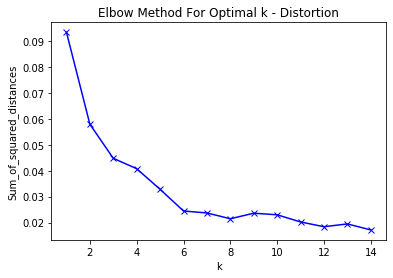

In [22]:
from scipy.spatial.distance import cdist 
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_izmir_home_clustering_normalized)
    #Sum_of_squared_distances.append(km.inertia_)
    
    Sum_of_squared_distances.append(sum(np.min(cdist(df_izmir_home_clustering_normalized, km.cluster_centers_, 
                 'euclidean'),axis=1)) / df_izmir_home_clustering_normalized.shape[0] )
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - Distortion')
plt.show()

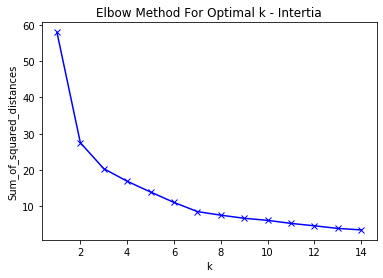

In [23]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_izmir_home_clustering_normalized)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k - Intertia')
plt.show()

Above results shows K=6 is appropriate value

In [24]:
# set number of clusters based on above results
kclusters = 6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(df_izmir_home_clustering_normalized)

# check cluster labels generated for each row in the dataframe
kmeans.labels_;

In [25]:
df_houses.insert(0, 'House Cluster', kmeans.labels_)

In [26]:
df_houses.groupby(['House Cluster']).size()

House Cluster
0    1361
1     758
2     692
3     858
4     193
5     962
dtype: int64

---
## Visualise Some Data

In [27]:

df_temp = df_houses.drop(['Borough','Link'],axis=1)
df_temp = df_temp[(np.abs(stats.zscore(df_temp)) < 3).all(axis=1)] #remove outliers
df_temp = df_temp[(np.abs(stats.zscore(df_temp)) < 3).all(axis=1)] #remove outliers


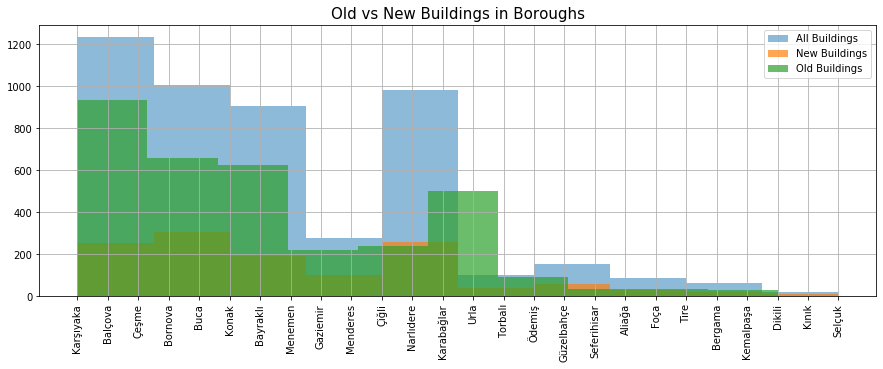

In [28]:
viz = df_temp[['Price','Size','Age','P/m2']]
#viz.hist();
df_houses['Borough'].hist(figsize=(15,5),xrot=90,label='All Buildings',alpha=0.5);
df_houses[df_houses['Age']<5]['Borough'].hist(figsize=(15,5),xrot=90,label='New Buildings',alpha=0.7);
df_houses[df_houses['Age']>5]['Borough'].hist(figsize=(15,5),xrot=90,label='Old Buildings',alpha=0.7);
plt.title('Old vs New Buildings in Boroughs',size=15);
plt.legend();

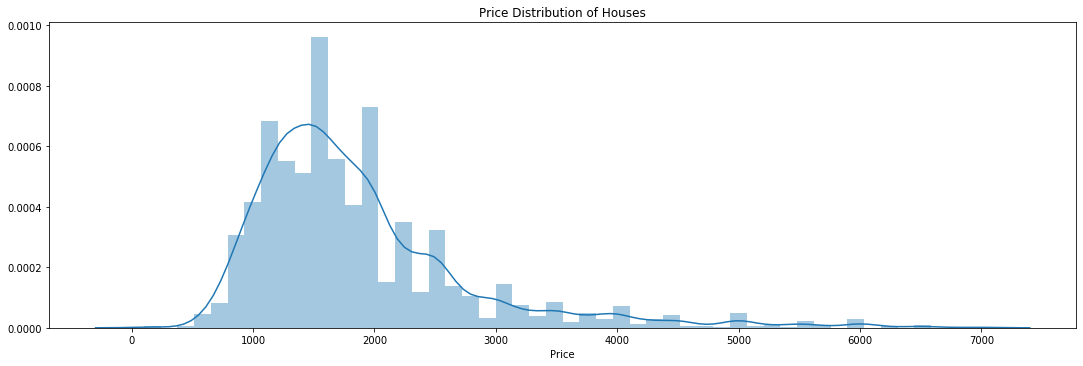

In [29]:
plt.figure(figsize=(15,5))
plt.title('Price Distribution of Houses')
plt.tight_layout()
seabornInstance.distplot(df_temp['Price']);

# Use the FourSquare API

In [31]:
# @hidden_cell
CLIENT_ID = '4JSYXIQ50L0P0IW5PYW133NFXGZOHRMDXFCVQLGCZYXXDAGM' # your Foursquare ID
CLIENT_SECRET = '1XXE5UWKLBSFUT3RCWCCDYM04ZOEL0UQEQOTAPD0YGJOTPKV' # your Foursquare Secret
VERSION = '20180604'

In [32]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
search_query = ''
radius = 5000
latitude=38.503471 #&ll={},{}
longitude=27.113483
LIMIT = 100
df_nearby = pd.DataFrame(columns=['name', 'categories', 'lat', 'lng', 'Borough'] )
for borough in list(set(df_houses['Borough'])):
    near=(borough+",İzmir") #iterate here
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&near={}&v={}&query={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, near, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']
    nearby_venues = pd.json_normalize(venues)
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    
    nearby_venues['Borough'] = borough
    nearby_venues['Borough Latitude'] = list(set(df_houses[df_houses['Borough'] == borough]['Latitude']))[0]
    nearby_venues['Borough Longitude'] = list(set(df_houses[df_houses['Borough'] == borough]['Longitude']))[0]
    df_nearby=df_nearby.append(nearby_venues)
df_nearby

,name,categories,lat,lng,Borough,Borough Latitude,Borough Longitude
0,Ödemiş Yıldız Kent Arşivi ve Müzesi (ÖYKAM),History Museum,38.226990,27.969595,Ödemiş,38.231341,27.975181
1,Köfteci Halil ÇARIKCI,Steakhouse,38.229363,27.970096,Ödemiş,38.231341,27.975181
2,Dostol Kebap Salonu,Comfort Food Restaurant,38.229145,27.973746,Ödemiş,38.231341,27.975181
3,Ödemiş Meşhur Köfteci İsmail,Steakhouse,38.229647,27.969806,Ödemiş,38.231341,27.975181
4,Kardelen Pide Ve Lahmacun Salonu,Bakery,38.228964,27.968276,Ödemiş,38.231341,27.975181
...,...,...,...,...,...,...,...
95,Gizli sahil,Beach,38.397508,26.984567,Narlıdere,38.372569,26.975152
96,Taka Balık Evi,Seafood Restaurant,38.406432,26.997929,Narlıdere,38.372569,26.975152
97,Balçova Termal Otel,Hotel,38.387449,27.034793,Narlıdere,38.372569,26.975152
98,Buckin Coffee Co.,Coffee Shop,38.393881,27.046481,Narlıdere,38.372569,26.975152


In [34]:
from IPython.display import display
pd.options.display.max_rows = None
#display(df_nearby)


In [35]:
df_venues = df_nearby.copy()
df_venues=df_venues.rename(columns={'name':'Venue', 'lat':'Venue Latitude', 'lng':'Venue Longitude', 'categories':'Venue Category'})

### Analyze Each Borough

In [36]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Borough'] = df_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Borough,ATM,Accessories Store,Airport,American Restaurant,Amphitheater,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Veterinarian,Volleyball Court,Water Park,Waterfront,Wedding Hall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Ödemiş,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ödemiş,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ödemiş,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ödemiş,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ödemiş,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
izmir_grouped = df_onehot.groupby('Borough').mean().reset_index()
izmir_grouped.head()

,Borough,ATM,Accessories Store,Airport,American Restaurant,Amphitheater,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Veterinarian,Volleyball Court,Water Park,Waterfront,Wedding Hall,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Aliağa,0.01,0.0,0.0,0.0,0.00,0.010000,0.00,0.0,0.0,...,0.0,0.0,0.02,0.020000,0.0,0.0,0.0,0.0,0.00,0.0
1,Balçova,0.00,0.0,0.0,0.0,0.00,0.010000,0.02,0.0,0.0,...,0.0,0.0,0.00,0.050000,0.0,0.0,0.0,0.0,0.00,0.0
2,Bayraklı,0.00,0.0,0.0,0.0,0.00,0.042857,0.00,0.0,0.0,...,0.0,0.0,0.00,0.028571,0.0,0.0,0.0,0.0,0.00,0.0
3,Bergama,0.00,0.0,0.0,0.0,0.01,0.020000,0.00,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.01,0.0
4,Bornova,0.00,0.0,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.0


In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = izmir_grouped['Borough']

for ind in np.arange(izmir_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(izmir_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aliağa,Restaurant,Café,Beach,Seafood Restaurant,Turkish Restaurant,Fast Food Restaurant,Hotel,Coffee Shop,Pide Place,Gym / Fitness Center
1,Balçova,Seafood Restaurant,Café,Turkish Restaurant,Waterfront,Coffee Shop,Gym / Fitness Center,Restaurant,Pide Place,Mountain,Dessert Shop
2,Bayraklı,Café,Bakery,Arcade,Restaurant,Convenience Store,Pharmacy,Pide Place,Waterfront,Farmers Market,Breakfast Spot
3,Bergama,Café,Historic Site,Hotel,Bar,Beer Garden,Breakfast Spot,Dessert Shop,Restaurant,Turkish Restaurant,Jewelry Store
4,Bornova,Café,Restaurant,Turkish Restaurant,Meyhane,Dessert Shop,Coffee Shop,Gym,Gym / Fitness Center,Pastry Shop,Park


### Bar Graph venue frequency in each borough

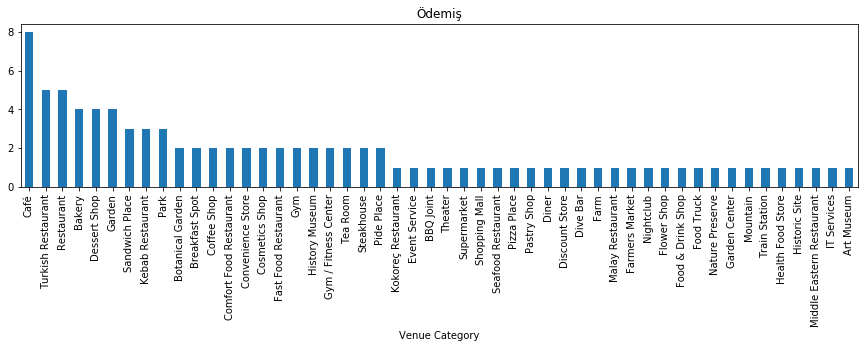

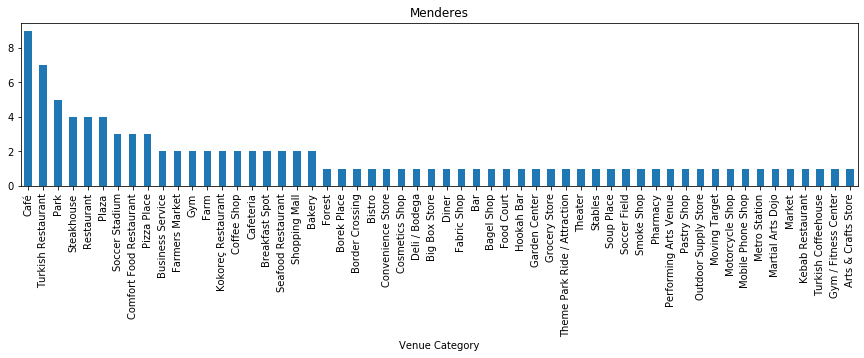

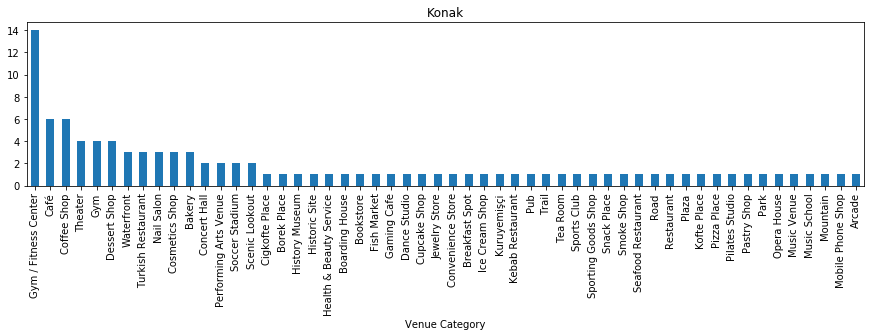

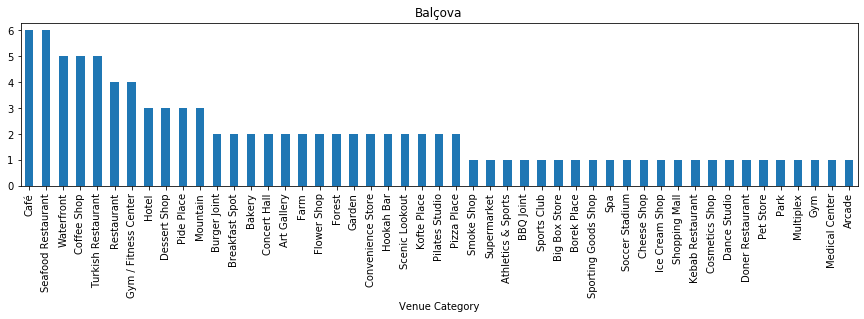

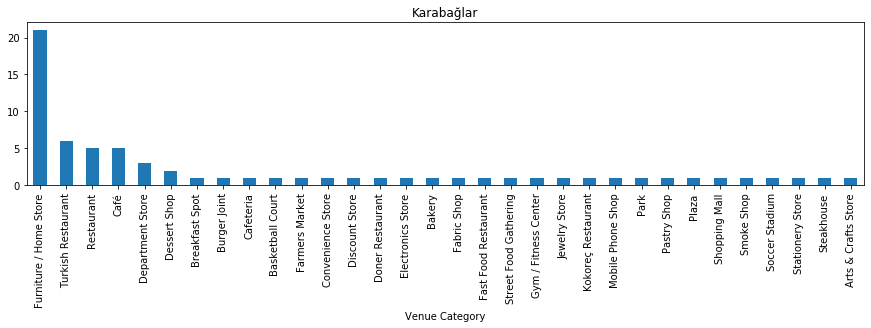

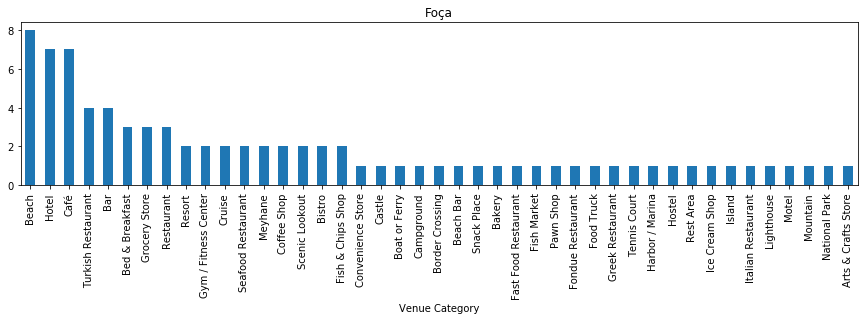

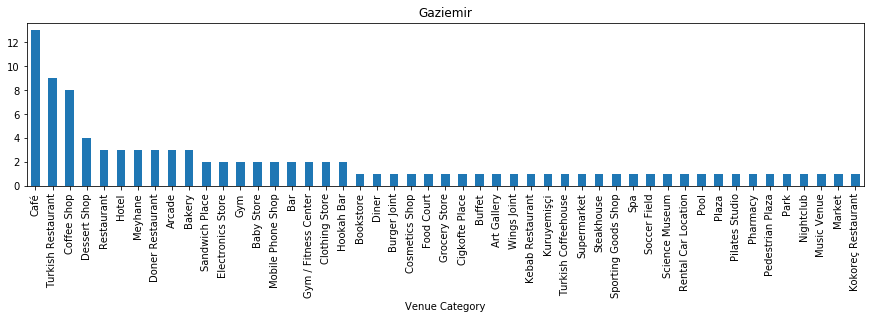

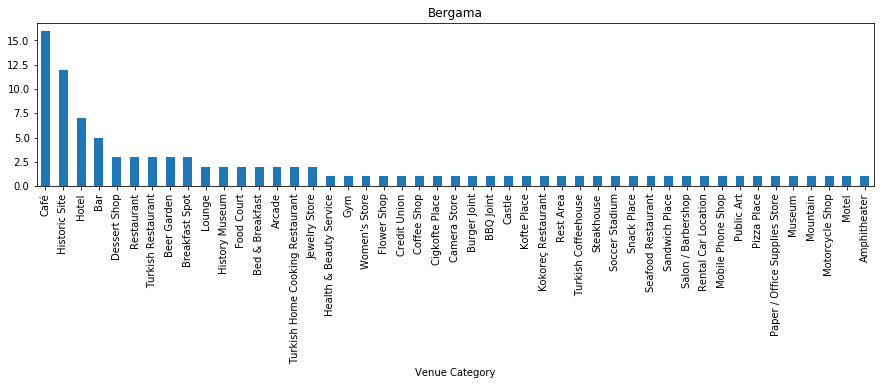

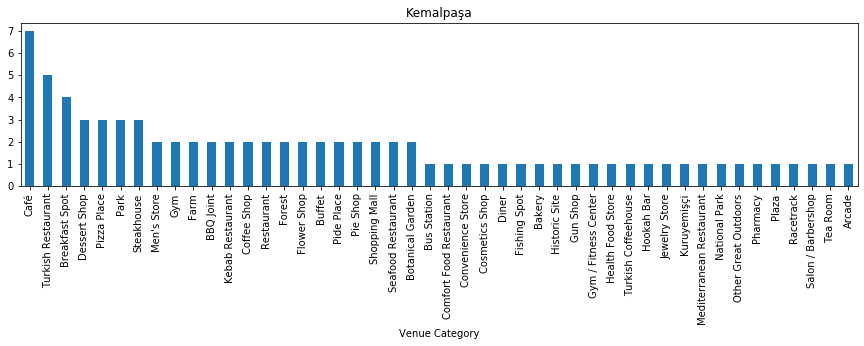

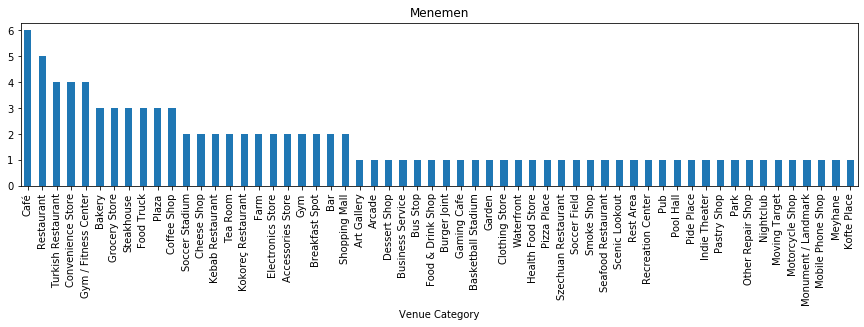

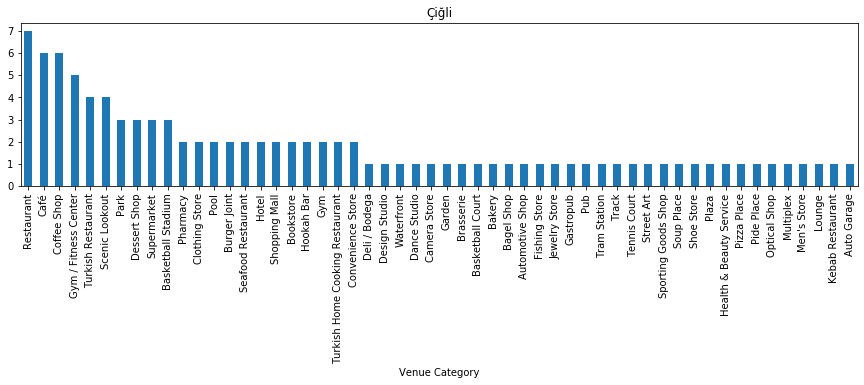

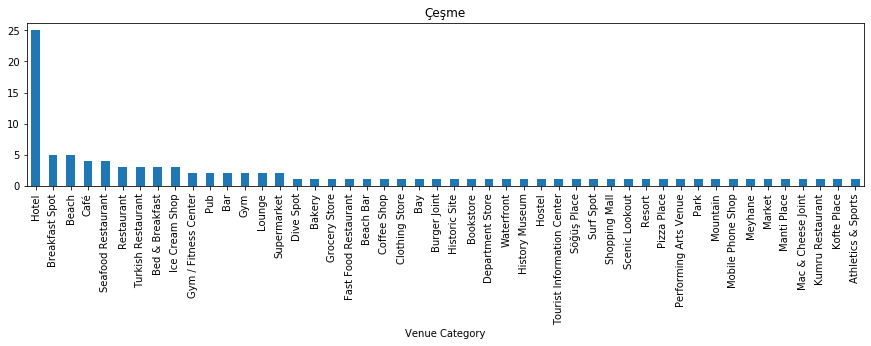

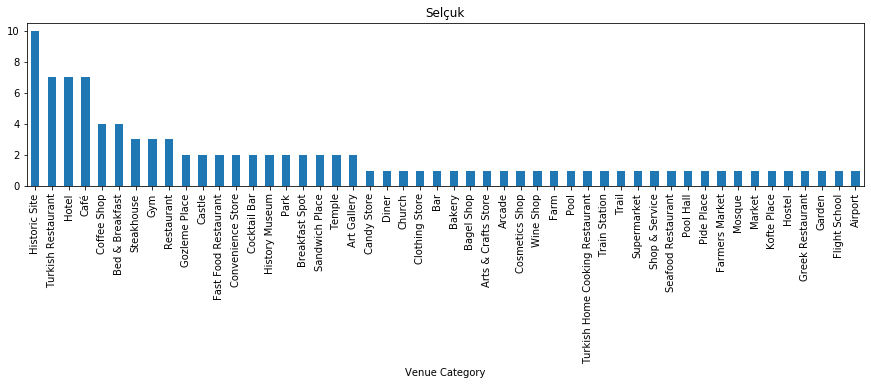

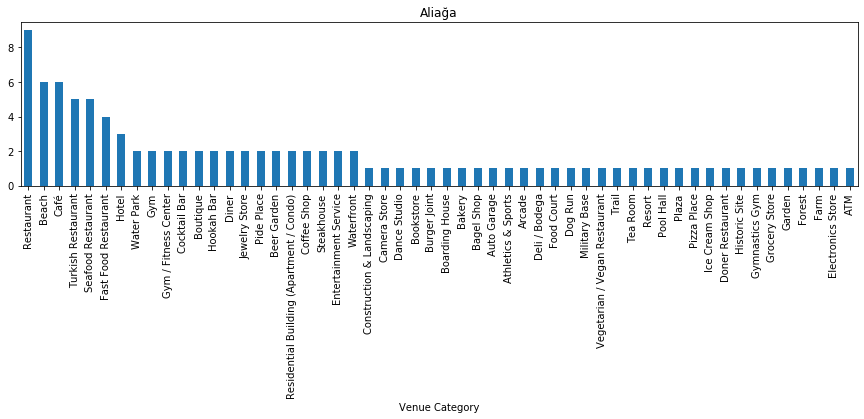

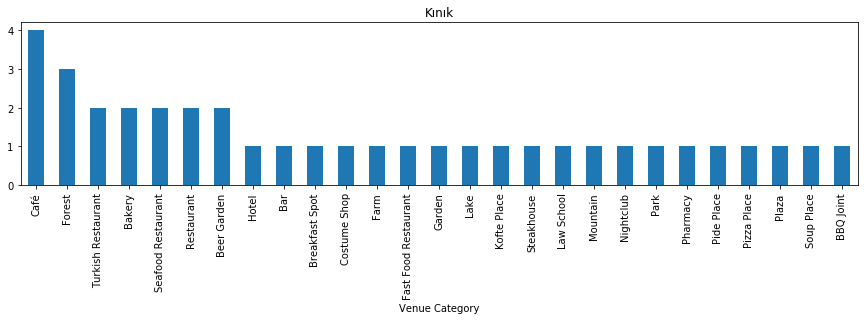

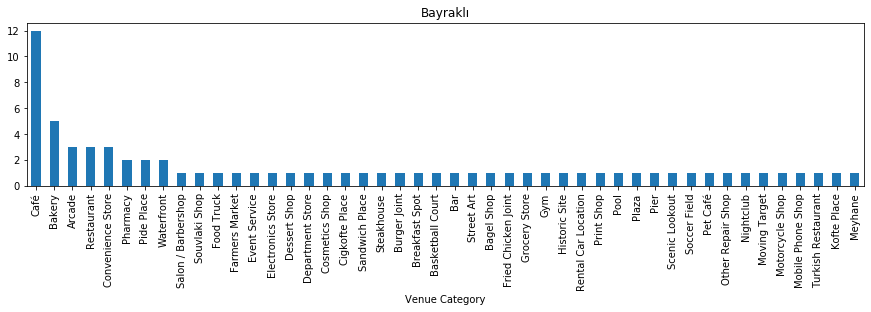

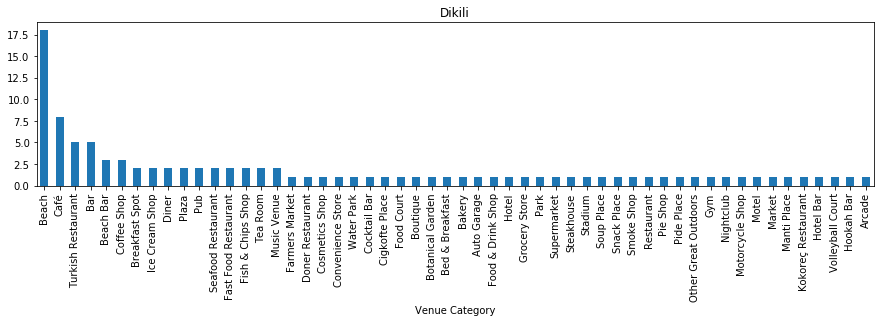

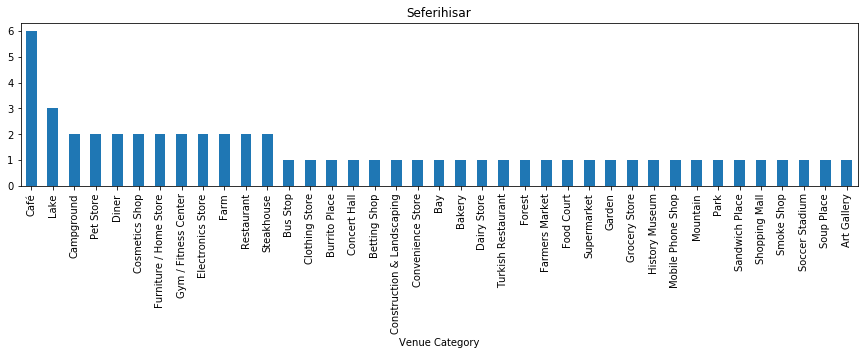

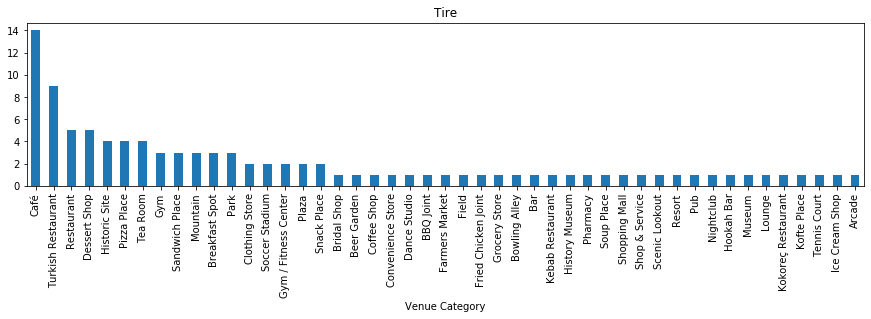

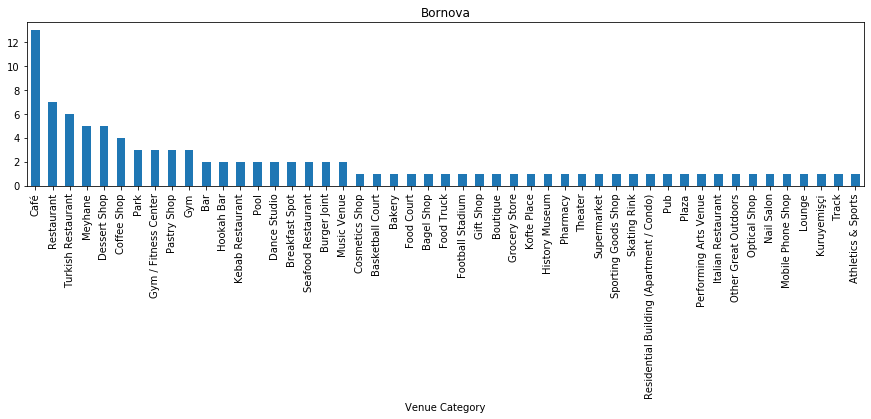

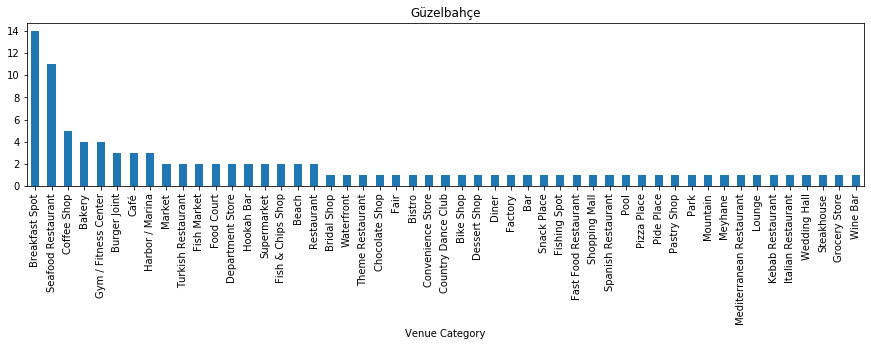

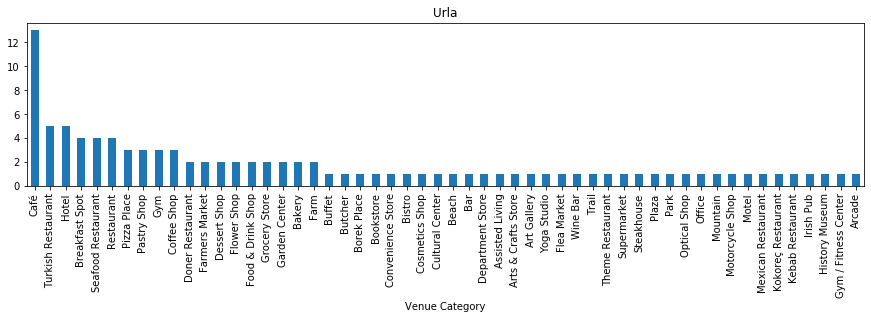

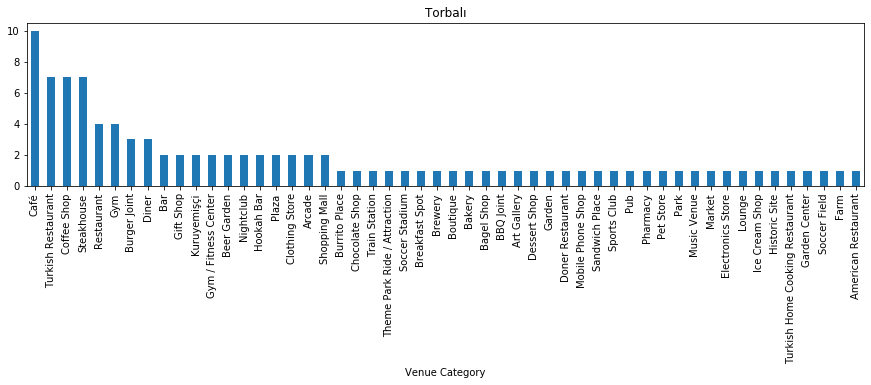

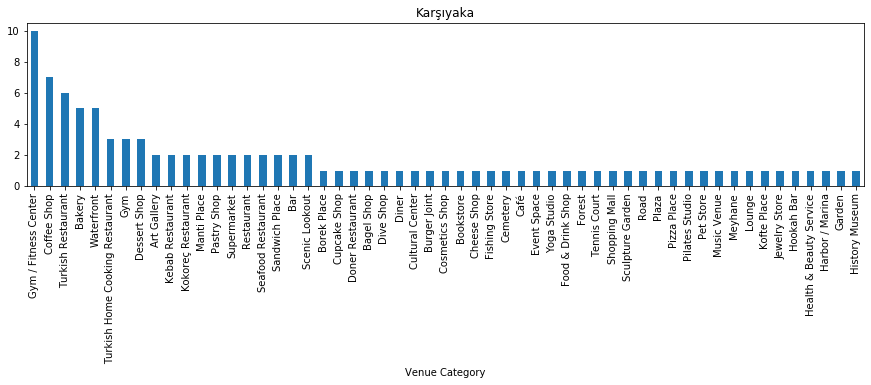

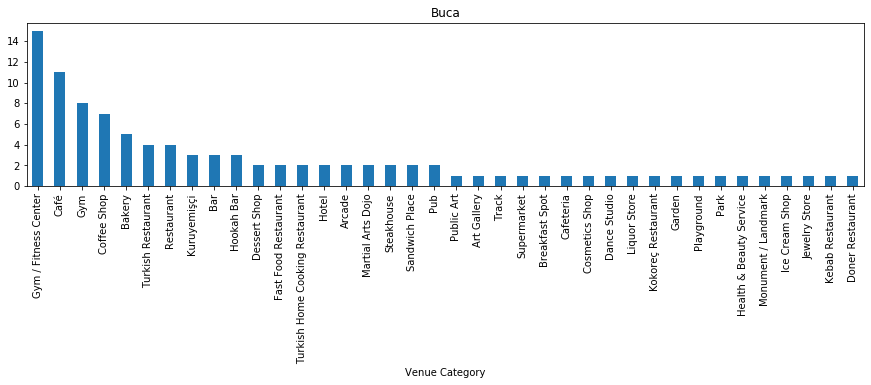

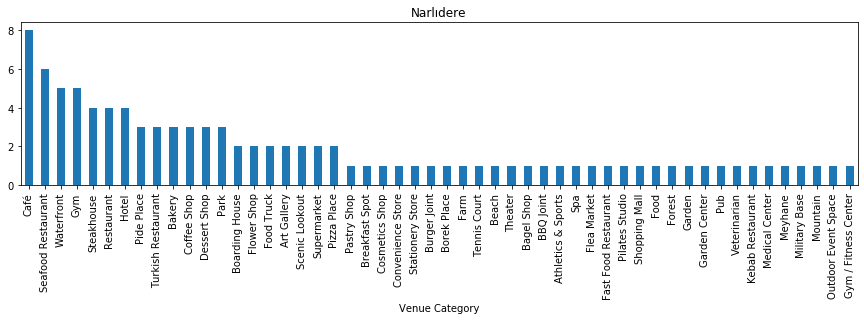

In [40]:
plt.rcParams.update({'figure.max_open_warning': 0})
boroughs=(list(set(df_venues['Borough'])))
for borough in boroughs:
    plt.figure()
    temp=df_venues.groupby(['Borough','Venue Category']).size()[borough].sort_values(ascending=False)
    temp.plot.bar(figsize=(15,3))
    plt.title(borough)

## Cluster Boroughs by Venues

In [41]:
# set number of clusters
kclusters = 6

izmir_venue_clustering = izmir_grouped.drop('Borough', 1)

# run k-means clustering
kmeans_venue = KMeans(n_clusters=kclusters, random_state=0).fit(izmir_venue_clustering)

# check cluster labels generated for each row in the dataframe
kmeans_venue.labels_[0:10] 

array([1, 1, 0, 0, 0, 2, 5, 5, 0, 1])

In [42]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Venue Cluster', kmeans_venue.labels_)

izmir_merged = df_borough_lat_long

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
izmir_merged = izmir_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

izmir_merged.head() # check the last columns!

,Borough,Latitude,Longitude,Venue Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ödemiş,38.231341,27.975181,1,Café,Restaurant,Turkish Restaurant,Bakery,Garden,Dessert Shop,Kebab Restaurant,Park,Sandwich Place,Pide Place
1,Menderes,38.149147,27.106591,1,Café,Turkish Restaurant,Park,Steakhouse,Restaurant,Plaza,Pizza Place,Comfort Food Restaurant,Soccer Stadium,Farmers Market
2,Balçova,38.380478,27.055728,1,Seafood Restaurant,Café,Turkish Restaurant,Waterfront,Coffee Shop,Gym / Fitness Center,Restaurant,Pide Place,Mountain,Dessert Shop
3,Konak,38.410958,27.129453,2,Gym / Fitness Center,Coffee Shop,Café,Theater,Dessert Shop,Gym,Bakery,Nail Salon,Cosmetics Shop,Turkish Restaurant
4,Karabağlar,38.347205,27.041274,4,Furniture / Home Store,Turkish Restaurant,Restaurant,Café,Department Store,Dessert Shop,Mobile Phone Shop,Basketball Court,Discount Store,Fabric Shop


See venue clusters on map

In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(izmir_merged['Latitude'], izmir_merged['Longitude'], izmir_merged['Borough'], izmir_merged['Venue Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Merge Houses and Venue(Borough) Clusters

In [44]:
izmir_merged_trim = izmir_merged[['Borough','Venue Cluster']]
house_venues_merged = pd.merge(left=df_houses, right=izmir_merged_trim, left_on='Borough', right_on='Borough')

In [45]:
house_venues_merged.head()

,House Cluster,Price,Size,Borough,Room#,Age,Link,P/m2,Latitude,Longitude,Venue Cluster
0,2,1850,86,Karşıyaka,2,7,www.hurriyetemlak.com/izmir-karsiyaka-ornekkoy...,22.0,38.503471,27.113483,2
1,2,1800,65,Karşıyaka,2,2,www.hurriyetemlak.com/izmir-karsiyaka-alaybey-...,28.0,38.503471,27.113483,2
2,5,2650,145,Karşıyaka,4,1,www.hurriyetemlak.com/izmir-karsiyaka-yali-kir...,18.0,38.503471,27.113483,2
3,1,3500,98,Karşıyaka,3,11,www.hurriyetemlak.com/izmir-karsiyaka-mavisehi...,36.0,38.503471,27.113483,2
4,1,3400,104,Karşıyaka,3,12,www.hurriyetemlak.com/izmir-karsiyaka-yali-kir...,33.0,38.503471,27.113483,2


# Recommend Houses to User

In [46]:
print('Please enter your search criterias approximately:')
user_price = int(input('RENT[TL]:'))
user_size = int(input('SIZE[m2]:'))
user_age = int(input('AGE[Years]:'))
user_rooms = int(input('ROOM#[3+1=4]:'))
user_pm2 = user_price/user_size

user_borough = input('Enter your favourite borough:')
user_data = [user_price, user_size, user_rooms, user_age, user_pm2]

input_normalized = min_max_scaler.transform([user_data])
prediction=(kmeans.predict(input_normalized))
print('user cluster: ' + str(prediction[0]))

Please enter your search criterias approximately:
RENT[TL]:3000
SIZE[m2]:120
AGE[Years]:4
ROOM#[3+1=4]:4
Enter your favourite borough:Karşıyaka
user cluster: 5


In [47]:
#filter by House Cluster
df_filter_house=house_venues_merged.loc[house_venues_merged['House Cluster'] == prediction[0]] 
#find venue cluster from users favourite borough
user_venue_cluster = list(house_venues_merged[house_venues_merged['Borough'] == user_borough]['Venue Cluster'])[0] 
#filter by venue cluster
df_filter_venue=df_filter_house[df_filter_house['Venue Cluster'] == user_venue_cluster]

recommend=5
print('One of the {} houses below is suitable for you'.format(recommend))
recommend_houses= df_filter_venue.sample(recommend)
for i in range(recommend):
    display(HTML("""<a href="http://{}">Recommended House {}</a>""".format(list(recommend_houses['Link'])[i], i+1)))
recommend_houses.drop(['Link'],axis=1)

One of the 5 houses below is suitable for you


,House Cluster,Price,Size,Borough,Room#,Age,P/m2,Latitude,Longitude,Venue Cluster
232,5,5250,200,Karşıyaka,4,4,26.0,38.503471,27.113483,2
1945,5,1350,130,Buca,4,15,10.0,38.344461,27.262772,2
1828,5,1600,135,Buca,4,10,12.0,38.344461,27.262772,2
560,5,2700,155,Karşıyaka,4,16,17.0,38.503471,27.113483,2
413,5,2100,160,Karşıyaka,4,7,13.0,38.503471,27.113483,2
